In [1]:
import os
import gc

os.chdir('../../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from global_code.util import reduce_mem_usage
import matplotlib.pyplot as plt
import seaborn as sns
from global_code.util import reduce_mem_usage, clf_metric_report, compute_and_plot_permutation_importance, plot_pr_calib_curve, plot_dis_probs, plot_shap_values
import optuna
import arfs.feature_selection.allrelevant as arfsgroot
import shap
import json
import joblib
from venn_abers import VennAbersCalibrator

sns.set(style='whitegrid')

/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read train, validation and calibration data

In [4]:
train_df = pd.read_parquet('./week_1/data/processed/train_df.parquet')
validation_df = pd.read_parquet('./week_1/data/processed/validation_df.parquet')
calibration_df = pd.read_parquet('./week_1/data/processed/calibration_df.parquet')

In [5]:
cat_features = ['country', 'broad_job_category']
train_df[cat_features].dtypes

country               category
broad_job_category    category
dtype: object

### Train, Validation, Test Split

In [6]:
target = 'churn_420'

# Input variables and Target dataframes
X_train, y_train= train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (306649, 152) (306649,)
Validation shape:  (283510, 152) (283510,)
Calibration shape:  (70878, 152) (70878,)


In [7]:
print('Train Churn Values count:\n', y_train.value_counts())
print(y_train.value_counts(normalize=True))

Train Churn Values count:
 churn_420
0    304795
1      1854
Name: count, dtype: int64
churn_420
0    0.993954
1    0.006046
Name: proportion, dtype: float64


In [8]:
print('Validation Churn Values count:\n', y_validation.value_counts())
print(y_validation.value_counts(normalize=True))

Validation Churn Values count:
 churn_420
0    279559
1      3951
Name: count, dtype: int64
churn_420
0    0.986064
1    0.013936
Name: proportion, dtype: float64


In [9]:
print('Calibration Churn Values count:\n', y_calibration.value_counts())
print(y_calibration.value_counts(normalize=True))

Calibration Churn Values count:
 churn_420
0    69890
1      988
Name: count, dtype: int64
churn_420
0    0.986061
1    0.013939
Name: proportion, dtype: float64


### Train a Vanilla Baseline CatBoost Model

In [10]:
# Using PRAUC Use Weights False to not inflat the PRAUC metric
baseline_params = {
    'iterations': 1000,
    'auto_class_weights': 'Balanced',
    'eval_metric': 'PRAUC:use_weights=false',
    'cat_features': cat_features,
    'verbose': True,
    'random_seed': 55,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'learning_rate': 0.02,
    'early_stopping_rounds': 100
}
model = CatBoostClassifier(**baseline_params)

print('Traning the model...')
model.fit(X_train, y_train, eval_set=(X_validation, y_validation), early_stopping_rounds=100)

print('Evaluating the model...')
y_pred_baseline = model.predict_proba(X_validation)[:, 1]

Traning the model...
0:	learn: 0.0167737	test: 0.0229074	best: 0.0229074 (0)	total: 178ms	remaining: 2m 57s
1:	learn: 0.0214266	test: 0.0227136	best: 0.0229074 (0)	total: 278ms	remaining: 2m 18s
2:	learn: 0.0165856	test: 0.0244775	best: 0.0244775 (2)	total: 375ms	remaining: 2m 4s
3:	learn: 0.0177142	test: 0.0249954	best: 0.0249954 (3)	total: 474ms	remaining: 1m 58s
4:	learn: 0.0179003	test: 0.0251946	best: 0.0251946 (4)	total: 576ms	remaining: 1m 54s
5:	learn: 0.0195627	test: 0.0256235	best: 0.0256235 (5)	total: 680ms	remaining: 1m 52s
6:	learn: 0.0195572	test: 0.0260591	best: 0.0260591 (6)	total: 779ms	remaining: 1m 50s
7:	learn: 0.0192405	test: 0.0260014	best: 0.0260591 (6)	total: 897ms	remaining: 1m 51s
8:	learn: 0.0193786	test: 0.0264372	best: 0.0264372 (8)	total: 1.01s	remaining: 1m 50s
9:	learn: 0.0194121	test: 0.0262334	best: 0.0264372 (8)	total: 1.13s	remaining: 1m 52s
10:	learn: 0.0196786	test: 0.0261623	best: 0.0264372 (8)	total: 1.29s	remaining: 1m 56s
11:	learn: 0.0194192	t

In [11]:
# Metrics Report
clf_metric_report(y_pred_baseline, y_validation)

Evaluating the model...
ROC AUC: 0.6874491984817513
Brier Score: 0.27357068114462263
Average Precision: 0.02813379957569347
Log Loss: 0.7299075239299322


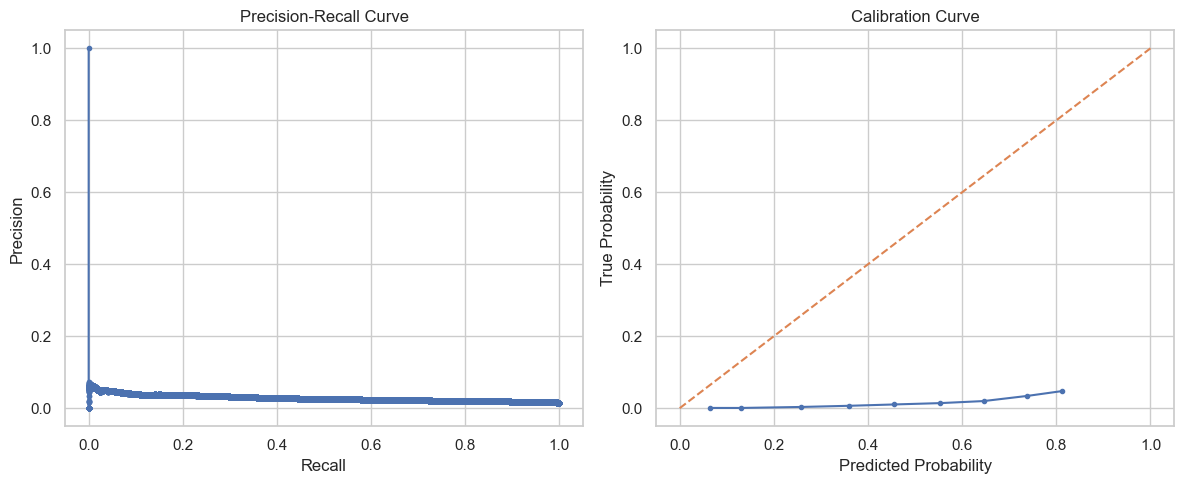

In [12]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_baseline, y_validation)

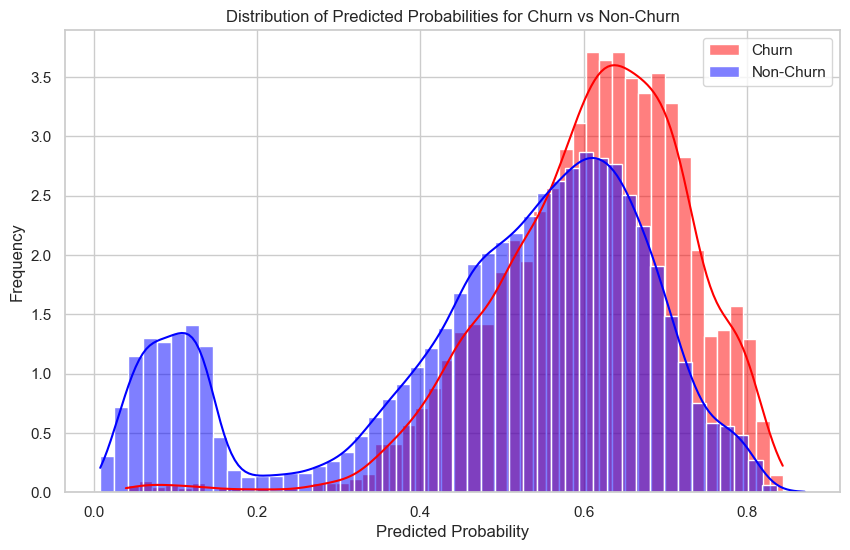

In [13]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_baseline, y_validation)

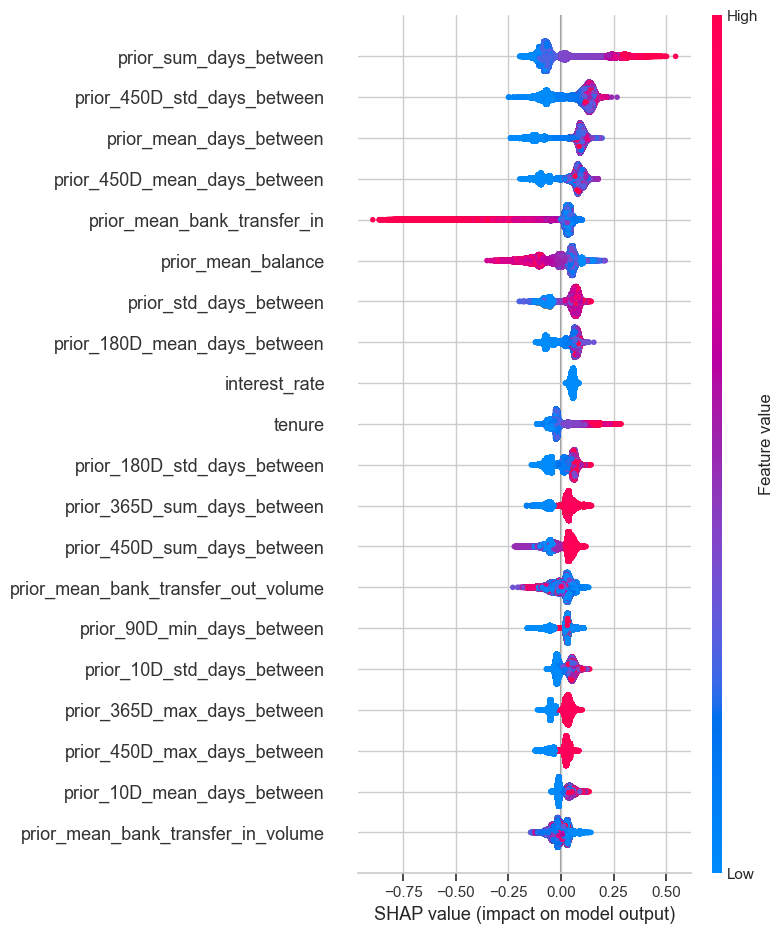

In [14]:
# SHAP Values
shap_explainer = shap.Explainer(model)
shap_values = shap_explainer(X_validation)
#shap.summary_plot(shap_values, X_validation, plot_type='dot', max_display=25)
shap.summary_plot(shap_values, X_validation)

### Feature Selection with Boruta

In [15]:
selected_features = None

In [16]:
# untuned, this is just a set of "reasonable defaults" to get better feature selection
feat_selection_params = {
    'random_strength': 1,
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    #'cat_features': cat_features,
    'verbose': False 
}

''''
Iteration: 	1 / 10
Confirmed: 	37
Tentative: 	47
Rejected: 	66
'''

model_for_feat_selection = CatBoostClassifier(**feat_selection_params) 

feat_selector = arfsgroot.Leshy(
    model_for_feat_selection, n_estimators=150, verbose=1, max_iter=10, random_state=55, importance="fastshap",
)

feat_selector.fit(X_train.drop(cat_features, axis=1), y_train)

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
Leshy iteration:  90%|█████████ | 9/10 [03:01<00:20, 20.14s/it]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	37
Tentative: 	47
Rejected: 	66
All relevant predictors selected in 00:03:01.50



The Leshy or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


Leshy(estimator=<catboost.core.CatBoostClassifier object at 0x2a71fa6d0>,
      importance='fastshap', max_iter=10, n_estimators=150,
      random_state=RandomState(MT19937) at 0x10828AC40, verbose=1)

The Leshy or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


Leshy(estimator=<catboost.core.CatBoostClassifier object at 0x2a71fa6d0>,
      importance='fastshap', max_iter=10, n_estimators=150,
      random_state=RandomState(MT19937) at 0x10828AC40, verbose=1)

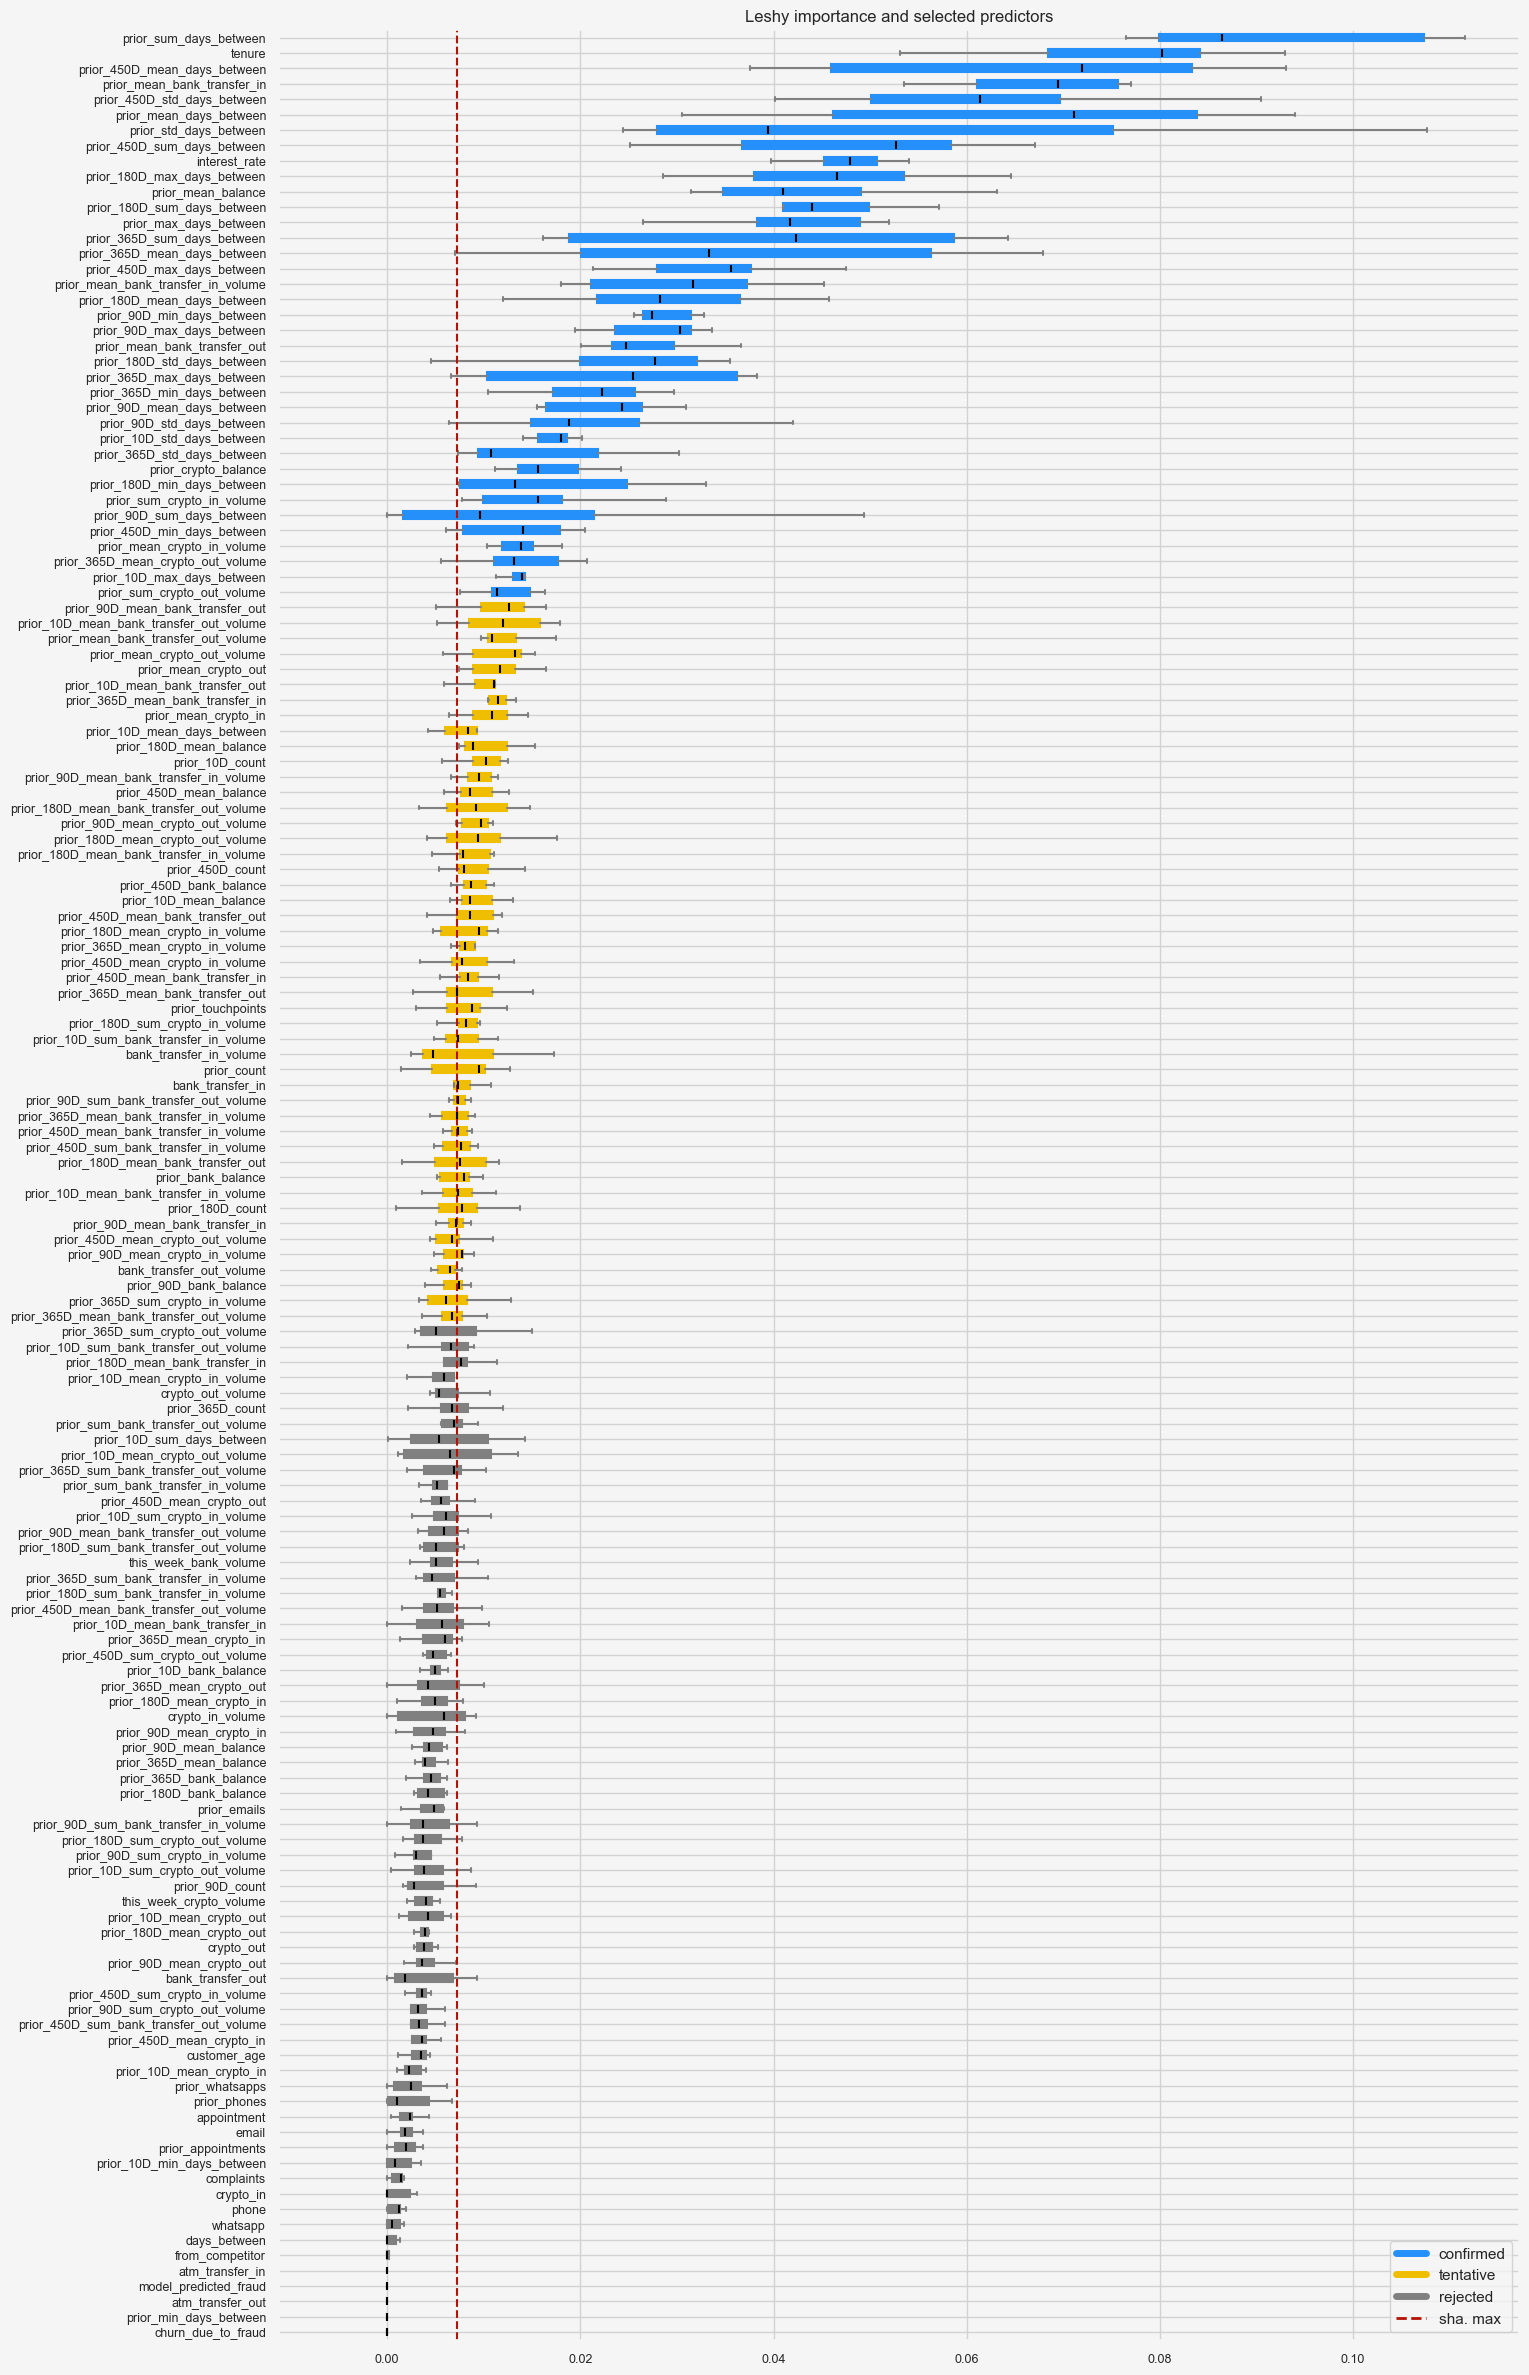

In [18]:
feat_selector.plot_importance()
_

In [19]:
selected_features = feat_selector.get_feature_names_out().tolist() + ['country', 'broad_job_category']


# Save the selected features
with open('./week_1/model/selected_features_list.json', 'w') as f:
    json.dump(selected_features, f)

In [20]:
print(f"The selected features: {selected_features}")

The selected features: ['interest_rate', 'tenure', 'prior_crypto_balance', 'prior_mean_balance', 'prior_sum_days_between', 'prior_std_days_between', 'prior_mean_days_between', 'prior_max_days_between', 'prior_mean_bank_transfer_in', 'prior_mean_bank_transfer_out', 'prior_mean_crypto_out', 'prior_mean_bank_transfer_in_volume', 'prior_mean_crypto_in_volume', 'prior_sum_crypto_in_volume', 'prior_sum_crypto_out_volume', 'prior_10D_std_days_between', 'prior_10D_mean_bank_transfer_out', 'prior_90D_mean_days_between', 'prior_90D_std_days_between', 'prior_90D_min_days_between', 'prior_90D_mean_bank_transfer_out', 'prior_90D_mean_bank_transfer_in_volume', 'prior_90D_mean_crypto_out_volume', 'prior_180D_sum_days_between', 'prior_180D_mean_days_between', 'prior_180D_max_days_between', 'prior_180D_min_days_between', 'prior_180D_mean_balance', 'prior_365D_sum_days_between', 'prior_365D_mean_days_between', 'prior_365D_std_days_between', 'prior_365D_min_days_between', 'prior_365D_mean_crypto_in_volum

### Train a Vanilla CatBoost Model with Selected Features

In [21]:
if selected_features == None:
    selected_features = ['interest_rate', 'tenure', 'prior_crypto_balance', 'prior_mean_balance', 'prior_sum_days_between', 'prior_std_days_between', 'prior_mean_days_between', 'prior_max_days_between', 'prior_mean_bank_transfer_in', 'prior_mean_bank_transfer_out', 'prior_mean_crypto_out', 'prior_mean_bank_transfer_in_volume', 'prior_mean_crypto_in_volume', 'prior_sum_crypto_in_volume', 'prior_sum_crypto_out_volume', 'prior_10D_std_days_between', 'prior_10D_mean_bank_transfer_out', 'prior_90D_mean_days_between', 'prior_90D_std_days_between', 'prior_90D_min_days_between', 'prior_90D_mean_bank_transfer_out', 'prior_90D_mean_bank_transfer_in_volume', 'prior_90D_mean_crypto_out_volume', 'prior_180D_sum_days_between', 'prior_180D_mean_days_between', 'prior_180D_max_days_between', 'prior_180D_min_days_between', 'prior_180D_mean_balance', 'prior_365D_sum_days_between', 'prior_365D_mean_days_between', 'prior_365D_std_days_between', 'prior_365D_min_days_between', 'prior_365D_mean_crypto_in_volume', 'prior_450D_sum_days_between', 'prior_450D_mean_days_between', 'prior_450D_std_days_between', 'prior_450D_max_days_between', 'country', 'broad_job_category']
    selected_features = selected_features + cat_features

model_selected = CatBoostClassifier(**baseline_params)
model_selected.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation), early_stopping_rounds=200, verbose=True)

y_pred_selected = model_selected.predict_proba(X_validation[selected_features])[:, 1]

0:	learn: 0.0171416	test: 0.0241905	best: 0.0241905 (0)	total: 85.1ms	remaining: 1m 25s
1:	learn: 0.0182729	test: 0.0274473	best: 0.0274473 (1)	total: 170ms	remaining: 1m 24s
2:	learn: 0.0194222	test: 0.0280153	best: 0.0280153 (2)	total: 256ms	remaining: 1m 25s
3:	learn: 0.0196209	test: 0.0278842	best: 0.0280153 (2)	total: 341ms	remaining: 1m 24s
4:	learn: 0.0200029	test: 0.0285347	best: 0.0285347 (4)	total: 426ms	remaining: 1m 24s
5:	learn: 0.0201342	test: 0.0284672	best: 0.0285347 (4)	total: 521ms	remaining: 1m 26s
6:	learn: 0.0199252	test: 0.0285822	best: 0.0285822 (6)	total: 603ms	remaining: 1m 25s
7:	learn: 0.0198162	test: 0.0291651	best: 0.0291651 (7)	total: 696ms	remaining: 1m 26s
8:	learn: 0.0199243	test: 0.0296533	best: 0.0296533 (8)	total: 781ms	remaining: 1m 26s
9:	learn: 0.0206528	test: 0.0291208	best: 0.0296533 (8)	total: 871ms	remaining: 1m 26s
10:	learn: 0.0211470	test: 0.0294851	best: 0.0296533 (8)	total: 966ms	remaining: 1m 26s
11:	learn: 0.0215217	test: 0.0294926	best

In [22]:
# Model metrics report
clf_metric_report(y_pred_selected, y_validation)

Evaluating the model...
ROC AUC: 0.6932547527225034
Brier Score: 0.2562781920929616
Average Precision: 0.02992709580252091
Log Loss: 0.7023102442145577


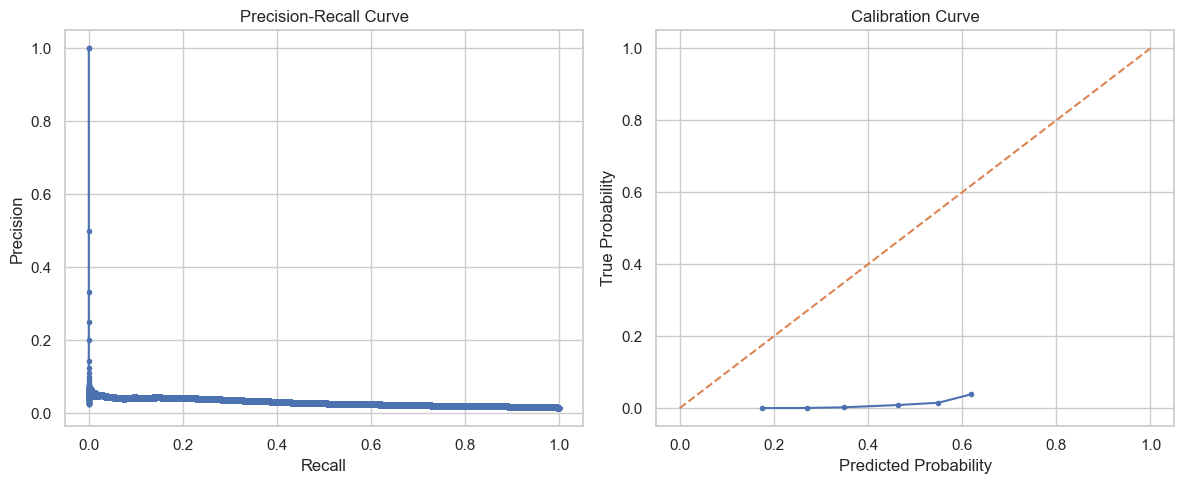

In [23]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_selected, y_validation)

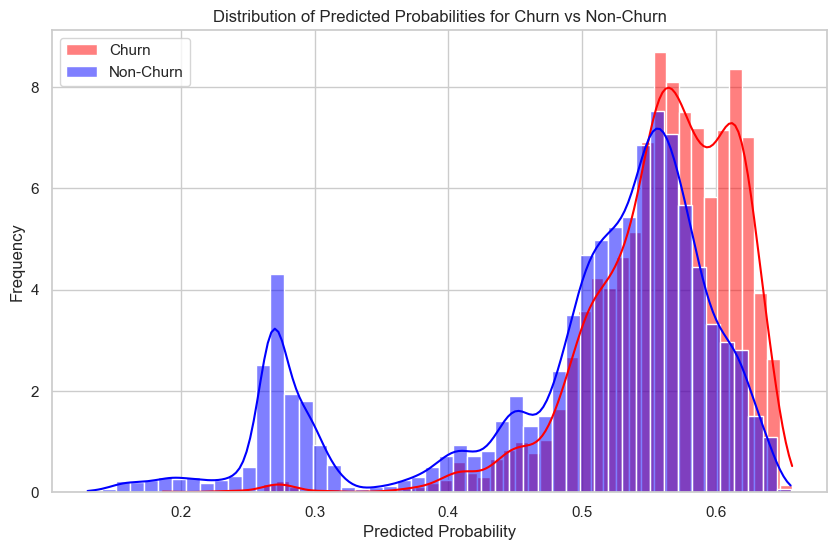

In [24]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_selected, y_validation)

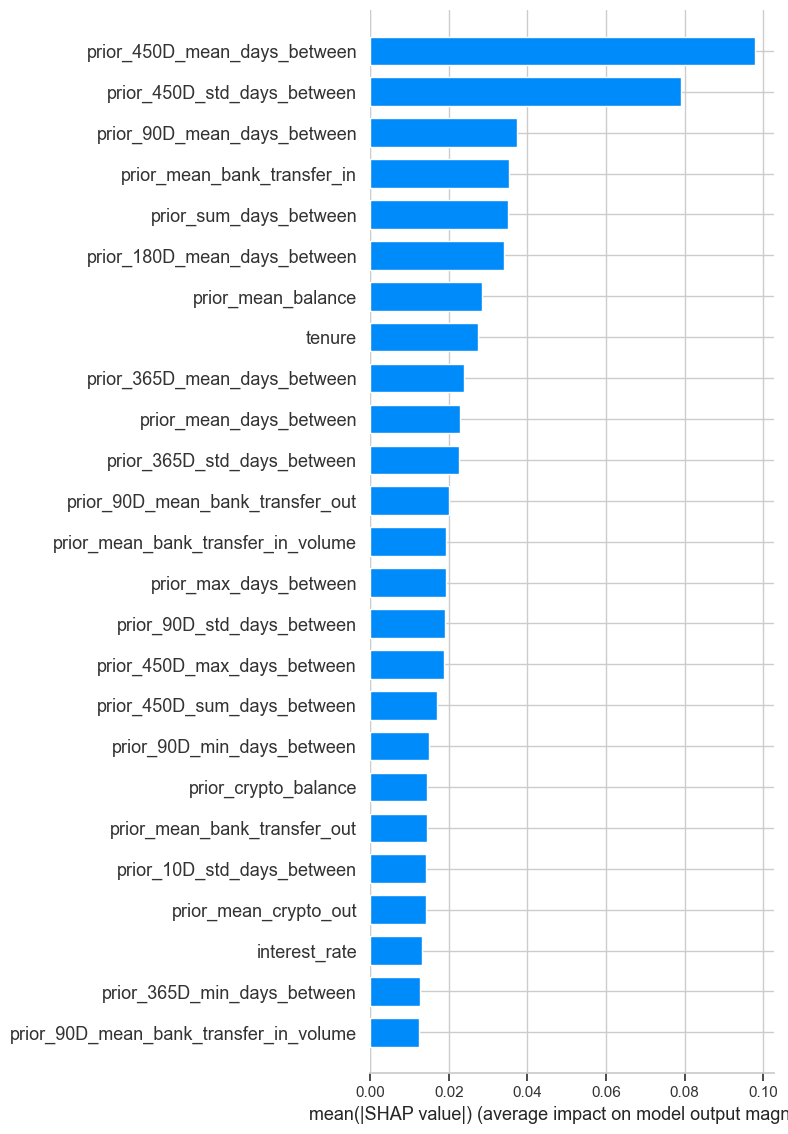

In [25]:
# SHAP Values
shape_explainer = shap.Explainer(model_selected)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

### Comparing Baseline and the Feature Selected model

In [26]:
print('Baseline model')
clf_metric_report(y_pred_baseline, y_validation)
print('')

print('Feature selection model')
clf_metric_report(y_pred_selected, y_validation)
print('')

Baseline model
Evaluating the model...
ROC AUC: 0.6874491984817513
Brier Score: 0.27357068114462263
Average Precision: 0.02813379957569347
Log Loss: 0.7299075239299322

Feature selection model
Evaluating the model...
ROC AUC: 0.6932547527225034
Brier Score: 0.2562781920929616
Average Precision: 0.02992709580252091
Log Loss: 0.7023102442145577



In [ ]:
print('Average precision improvement: ', (average_precision_score(y_validation, y_pred_selected) - average_precision_score(y_validation, y_pred_baseline)) / average_precision_score(y_validation, y_pred_baseline))

Percentual average precision improvement:  0.06374170051231834


### Saving the model and artifacts

In [29]:
# Save the baseline model
baseline_model_path = './week_1/model/baseline_model.joblib'
joblib.dump(model, baseline_model_path)

# Save the model trained with selected features
feat_selection_model_path = './week_1/model/feat_selection_model.joblib'
joblib.dump(model_selected, feat_selection_model_path)

print(f"Baseline model saved to: {baseline_model_path}")
print(f"Baseline model saved to: {feat_selection_model_path}")

Baseline model saved to: ./week_1/model/baseline_model.joblib
Baseline model saved to: ./week_1/model/feat_selection_model.joblib
